In [1]:
from QuantLib import *


In [2]:
import matplotlib.pyplot as plt
import math
import ql_utils as utils

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
%%capture
%pylab inline --no-import-all


In [4]:
utils.set_default_plot_size()

In [5]:
today = Date(11, December, 2012)
Settings.instance().evaluationDate = today

In [6]:
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
            Period(1,Days), fixingDays,
            TARGET(), Following, False, Actual360())
for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)] ]

In [7]:
eonia = Eonia()

In [8]:
helpers += [ OISRateHelper(2, Period(*tenor),
             QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, tenor in [(0.070, (1,Weeks)), (0.069, (2,Weeks)),
                    (0.078, (3,Weeks)), (0.074, (1,Months))] ]

In [9]:
helpers += [ DatedOISRateHelper(start_date, end_date,
            QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, start_date, end_date in [
        (0.046, Date(16,January,2013), Date(13,February,2013)),
        (0.016, Date(13,February,2013), Date(13,March,2013)),
        (-0.007, Date(13,March,2013), Date(10,April,2013)),
        (-0.013, Date(10,April,2013), Date(8,May,2013)),
        (-0.014, Date(8,May,2013), Date(12,June,2013))] ]

In [10]:
helpers += [ OISRateHelper(2, Period(*tenor),
            QuoteHandle(SimpleQuote(rate/100)), eonia)
for rate, tenor in [
    (0.002, (15,Months)), (0.008, (18,Months)),
    (0.021, (21,Months)), (0.036, (2,Years)),
    (0.127, (3,Years)), (0.274, (4,Years)),
    (0.456, (5,Years)), (0.647, (6,Years)),
    (0.827, (7,Years)), (0.996, (8,Years)),
    (1.147, (9,Years)), (1.280, (10,Years)),
    (1.404, (11,Years)), (1.516, (12,Years)),
    (1.764, (15,Years)), (1.939, (20,Years)),
    (2.003, (25,Years)), (2.038, (30,Years))] ]

In [11]:
eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(), helpers, Actual365Fixed())

eonia_curve_c.enableExtrapolation()

In [12]:
today = eonia_curve_c.referenceDate()
end = today + Period(2,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

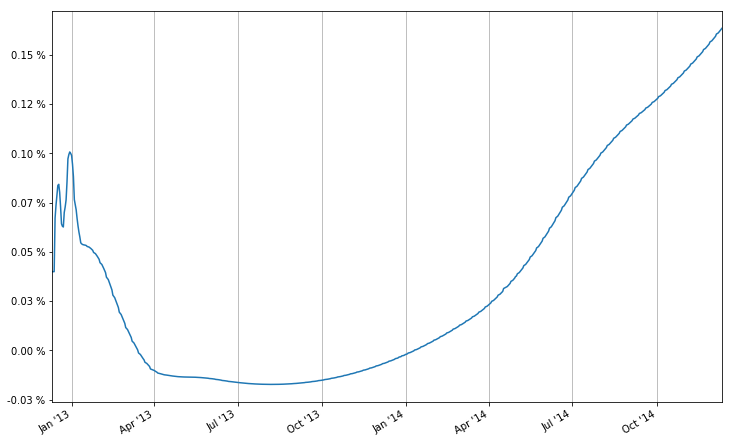

In [13]:
utils.plot_curve(plt, dates, [(rates_c,'-')])

In [14]:
eonia_curve_ff = PiecewiseFlatForward(0, TARGET(), helpers, Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

In [15]:
end = today + Period(6,Months)
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_ff = [ eonia_curve_ff.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

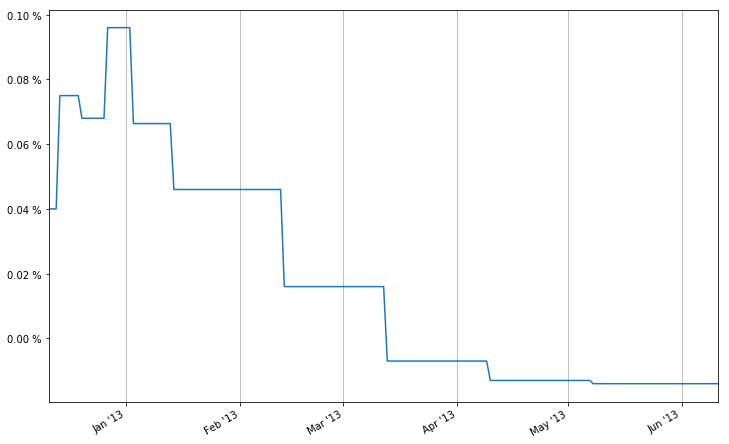

In [16]:
utils.plot_curve(plt, dates, [(rates_ff,'-')])

In [17]:
nodes = list(eonia_curve_ff.nodes())

In [18]:
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [19]:
nodes[6] = (nodes[6][0], (nodes[5][1]+nodes[7][1])/2.0)
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.000681123301587661),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [20]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())

In [21]:
temp_rates = [ temp_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

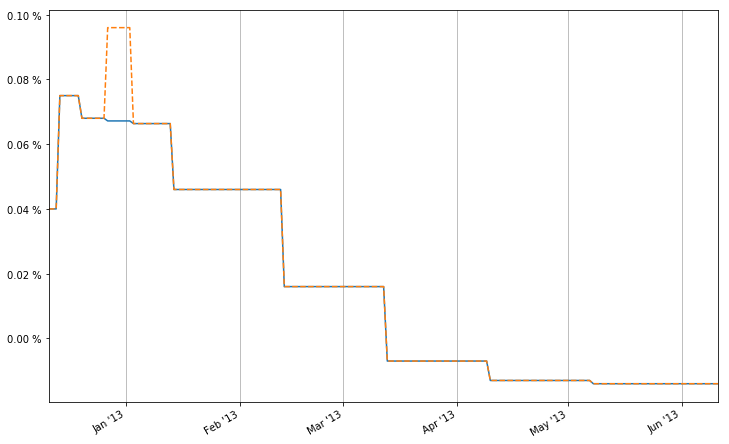

In [22]:
utils.plot_curve(plt, dates, [(temp_rates,'-'), (rates_ff,'--')])

In [23]:
d1 = Date(31,December,2012) - Period(1,Weeks)
d2 = Date(31,December,2012) + Period(1,Weeks)


In [24]:
F = eonia_curve_ff.forwardRate(d1, d2, Actual360(), Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, Actual360(), Simple).rate()
print(utils.format_rate(F,digits=3), utils.format_rate(F_1,digits=3))

0.082 % 0.067 %


In [25]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1,d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(Date(31,December,2012), Date(2,January,2013)) 
J = (F-F_1)*t12/t_j
print(utils.format_rate(J,digits=3))

0.101 %


In [26]:
B = 1.0/(1.0+J*t_j)
jumps = [QuoteHandle(SimpleQuote(B))]
jump_dates = [Date(31,December,2012)]
eonia_curve_j = PiecewiseFlatForward(0, TARGET(), helpers, Actual365Fixed(), jumps, jump_dates)

In [27]:
rates_j = [ eonia_curve_j.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate()for d in dates ]

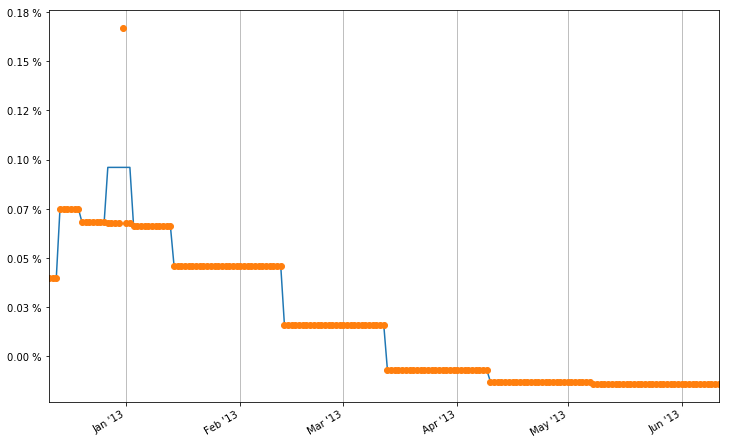

In [28]:
utils.plot_curve(plt, dates, [(rates_ff,'-'), (rates_j,'o')])

In [29]:
eonia_curve = PiecewiseLogCubicDiscount(0, TARGET(), helpers, Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()

In [30]:
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]

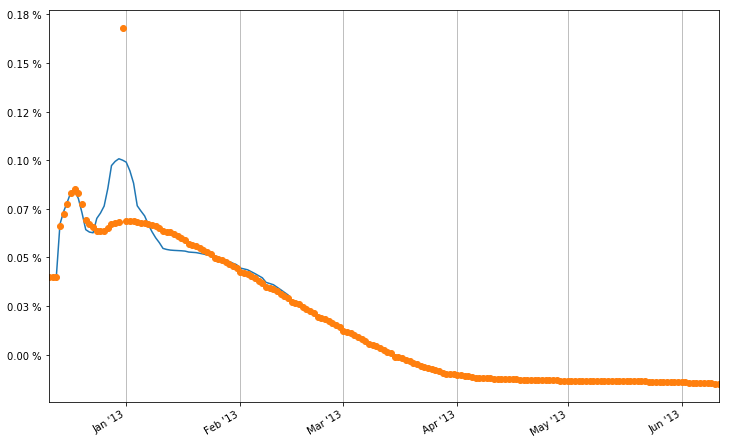

In [31]:
utils.plot_curve(plt, dates, [(rates_c,'-'), (rates,'o')])

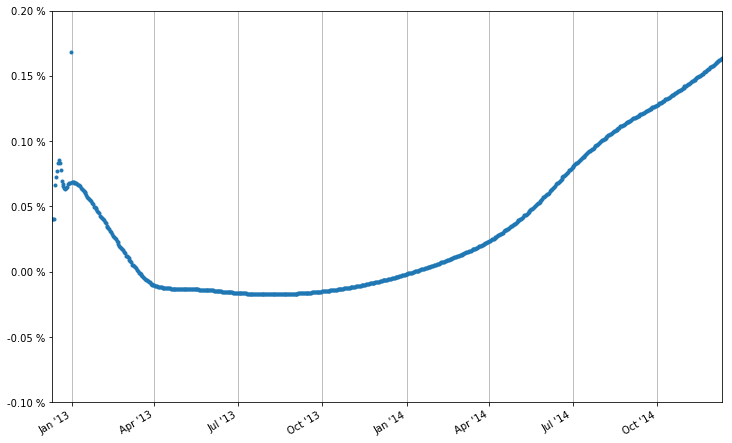

In [32]:
dates = [ today+Period(i,Days) for i in range(0, 365*2+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
utils.plot_curve(plt, dates, [(rates,'.')], ymin=-0.001, ymax=0.002)

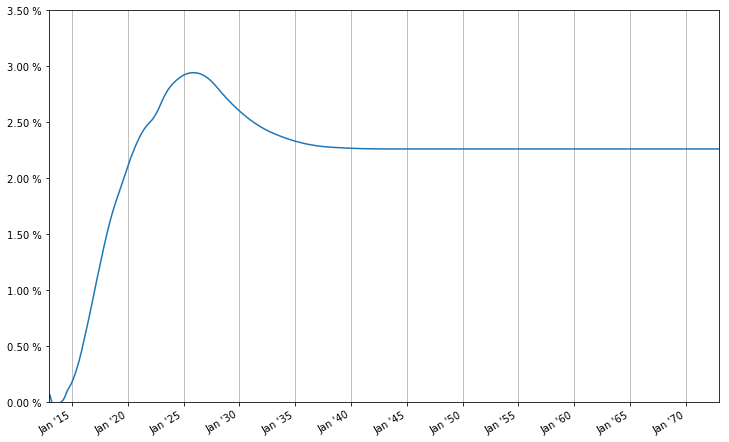

In [33]:
dates = [ today+Period(i,Months) for i in range(0, 12*60+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days), Actual360(), Simple).rate() for d in dates ]
utils.plot_curve(plt, dates, [(rates,'-')], ymin=0.0, ymax=0.035)